In [150]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
import scipy.optimize

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/fotonica04/Documentos/GitHub/Photonics-training/Projects/Hybrid4x4/InterconnectFiles')) #Current directory


###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Hybrid4x4/InterconnectFiles/'))
# spec_win.loader.exec_module(lumapi)

## Lumapi init

In [151]:
mmi = lumapi.INTERCONNECT(filename='Hybrid4x4.icp')

## Functions

In [152]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    #return A
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def linear(t,a,b):
    return a*t + b

In [153]:
Result_IN = mmi.getresult('OSC_1', 'signal')
Result_IP = mmi.getresult('OSC_2', 'signal')
Result_QN = mmi.getresult('OSC_3', 'signal')
Result_QP = mmi.getresult('OSC_4', 'signal')
time = Result_IN['time']
print(Result_IN.keys())

IN_sampled = Result_IN['amplitude (a.u.)']
IP_sampled = Result_IP['amplitude (a.u.)']
QN_sampled = Result_QN['amplitude (a.u.)']
QP_sampled = Result_QP['amplitude (a.u.)']
t = np.ndarray.flatten(time)

IN = np.ndarray.flatten(IN_sampled)
IP = np.ndarray.flatten(IP_sampled)
QN = np.ndarray.flatten(QN_sampled)
QP = np.ndarray.flatten(QP_sampled)
c = 299792458

KeyError: 'time'

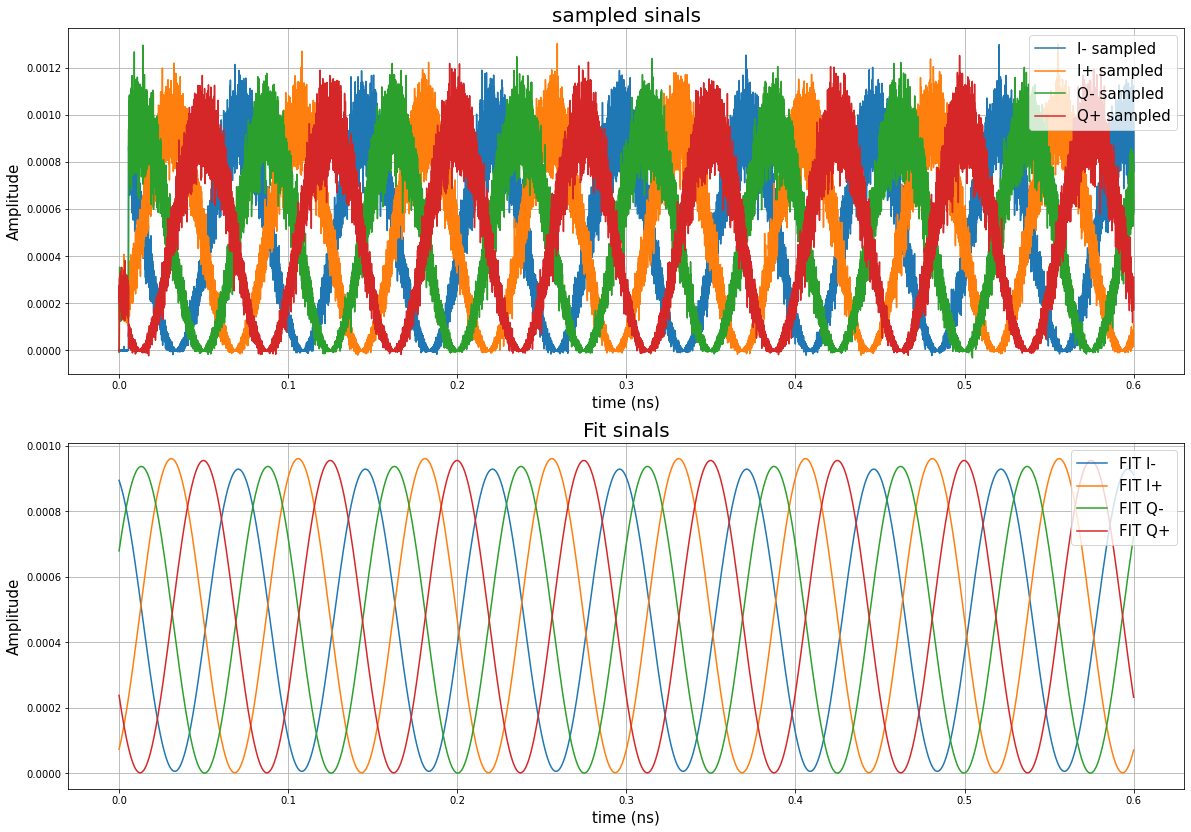

In [123]:
fig, ax= plt.subplots(2,1,figsize=(20,14))
ax[0].plot(time*1e9, IN_sampled, label = 'I- sampled')
ax[0].plot(time*1e9, IP_sampled, label = 'I+ sampled')
ax[0].plot(time*1e9, QN_sampled, label = 'Q- sampled')
ax[0].plot(time*1e9, QP_sampled, label = 'Q+ sampled')
#plt.xlim([0, 1])
ax[0].grid(True)
ax[0].set_xlabel('time (ns)',fontsize =15)
ax[0].set_ylabel('Amplitude',fontsize =15)
ax[0].set_title('sampled sinals',fontsize =20)
ax[0].legend(loc = 'upper right',fontsize =15)

fit_IN = fit_sin(t, IN)
fit_IP = fit_sin(t, IP)
fit_QN = fit_sin(t, QN)
fit_QP = fit_sin(t, QP)

ax[1].plot(time*1e9, fit_IN['amp']*np.sin(2*np.pi*fit_IN['freq']*t+fit_IN['phase'])+fit_IN['offset'], label = 'FIT I-')
ax[1].plot(time*1e9, fit_IP['amp']*np.sin(2*np.pi*fit_IP['freq']*t+fit_IP['phase'])+fit_IP['offset'], label = 'FIT I+')
ax[1].plot(time*1e9, fit_QN['amp']*np.sin(2*np.pi*fit_QN['freq']*t+fit_QN['phase'])+fit_QN['offset'], label = 'FIT Q-')
ax[1].plot(time*1e9, fit_QP['amp']*np.sin(2*np.pi*fit_QP['freq']*t+fit_QP['phase'])+fit_QP['offset'], label = 'FIT Q+')
ax[1].grid(True)
ax[1].set_xlabel('time (ns)',fontsize =15)
ax[1].set_ylabel('Amplitude',fontsize =15)
ax[1].set_title('Fit sinals',fontsize =20)
ax[1].legend(loc = 'upper right',fontsize =15)

In [125]:
print('------- Phase -------')
print(fit_IN['phase']*180/np.pi)
print(fit_IP['phase']*180/np.pi + 360) 
print(fit_QN['phase']*180/np.pi)
print(fit_QP['phase']*180/np.pi + 180)
print('------- Amp -------')
print(fit_IN['amp'])
print(fit_IP['amp'])
print(fit_QN['amp'])
print(fit_QP['amp'])
print('------- Freq -------')
print(fit_IN['freq'])
print(fit_IP['freq'])
print(fit_QN['freq'])
print(fit_QP['freq'])

------- Phase -------
112.22149402098326
301.69787195468194
26.679585462145788
210.2712448560809
------- Amp -------
0.0004615903508308511
0.0004797636386819612
0.0004683686277238829
-0.00047708106373868265
------- Freq -------
13304833302.216251
13331299974.254114
13362162031.380825
13337407454.817482


Text(0, 0.5, 'phase difference (degree)')

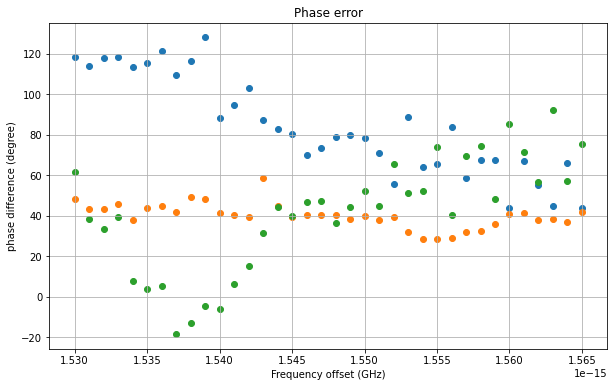

In [157]:
c = 299792458
CFreqArray = np.arange(1530e-9 , 1565e-9, 1e-9)
LaserArray = np.arange(0.25e-9 , 20e-9, 0.25e-9) # Prototype Laser Array
PError = np.zeros(len(CFreqArray))
PError2 = np.zeros(len(CFreqArray))
PError3 = np.zeros(len(CFreqArray))

DebugIP = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
DebugIN = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
DebugQP = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
DebugQN = np.zeros((len(LaserArray)+1 , len(CFreqArray)))

for j in range(len(CFreqArray)):
    LaserArray = np.arange(CFreqArray[j]+0.25e-9 , CFreqArray[j]+20e-9, 0.25e-9)
    PhaseArray = np.zeros((len(LaserArray)))
    PhaseArray2 = np.zeros((len(LaserArray)))
    PhaseArray3 = np.zeros((len(LaserArray)))
    FreqArray = abs(c/LaserArray - c/CFreqArray[j])
    mmi.switchtodesign()
    mmi.setnamed("CWL_2","frequency",c/CFreqArray[j])

    for i in range(len(LaserArray)):
        mmi.switchtodesign()
        mmi.setnamed("CWL_1","frequency",c/LaserArray[i])
        mmi.run()

        Result_IN = mmi.getresult('OSC_1', 'signal')
        Result_IP = mmi.getresult('OSC_2', 'signal')
        Result_QN = mmi.getresult('OSC_3', 'signal')
        Result_QP = mmi.getresult('OSC_4', 'signal')
        time = Result_IN['time']

        IN = np.ndarray.flatten(Result_IN['amplitude (a.u.)'])
        IP = np.ndarray.flatten(Result_IP['amplitude (a.u.)'])
        QN = np.ndarray.flatten(Result_QN['amplitude (a.u.)'])
        QP = np.ndarray.flatten(Result_QP['amplitude (a.u.)'])
        t = np.ndarray.flatten(time)

        fit_IN = fit_sin(t, IN)
        fit_IP = fit_sin(t, IP)
        fit_QN = fit_sin(t, QN)
        fit_QP = fit_sin(t, QP)

        IPhase = fit_IP['phase']*180/np.pi
        QPhase = fit_QP['phase']*180/np.pi
        IPhase2 = fit_IN['phase']*180/np.pi
        QPhase2 = fit_QN['phase']*180/np.pi

        # Debug Matrices
        DebugIP[i,j] = IPhase
        DebugIN[i,j] = IPhase2
        DebugQP[i,j] = QPhase
        DebugQN[i,j] = QPhase2
        
        # Verify if amplitude is negative
        if(fit_IP['amp'] < 0):
            IPhase = IPhase + 180
        if(fit_QP['amp'] < 0):
            QPhase = QPhase + 180
        if(fit_IN['amp'] < 0):
            IPhase2 = IPhase2 + 180
        if(fit_QN['amp'] < 0):
            QPhase2 = QPhase2 + 180

        # Offset 360
        if(IPhase < 0):
            IPhase = IPhase + 360
        if(QPhase < 0):
            QPhase = QPhase + 360
        if(IPhase2 < 0):
            IPhase2 = IPhase2 + 360
        if(QPhase2 < 0):
            QPhase2 = QPhase2 + 360

        PhaseArray[i] = abs(90 - abs(QPhase2 - IPhase))
        PhaseArray2[i] = abs(90 - abs(IPhase - QPhase))
        PhaseArray3[i] = abs(180 - abs(IPhase - IPhase2))

    linepoly = np.polyfit(FreqArray*1e-9,PhaseArray,1)
    linepoly2 = np.polyfit(FreqArray*1e-9,PhaseArray2,1)
    linepoly3 = np.polyfit(FreqArray*1e-9,PhaseArray3,1)
    PError[j] = linepoly[1]
    PError2[j] = linepoly2[1]
    PError3[j] = linepoly3[1]

fig = plt.figure(figsize = (10, 6))
plt.scatter(CFreqArray*1e-9,PError)
plt.scatter(CFreqArray*1e-9,PError2)
plt.scatter(CFreqArray*1e-9,PError3)
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset (GHz)')
plt.ylabel('phase difference (degree)')

Text(0, 0.5, 'phase error (degree)')

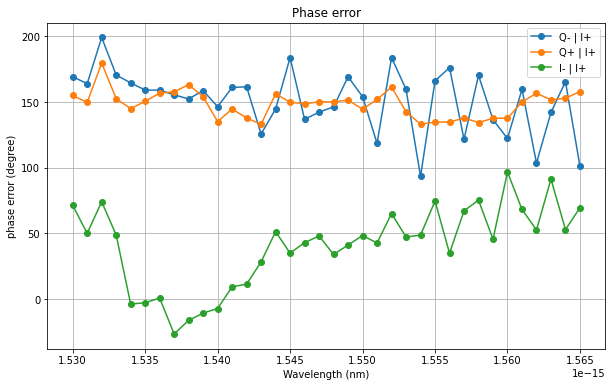

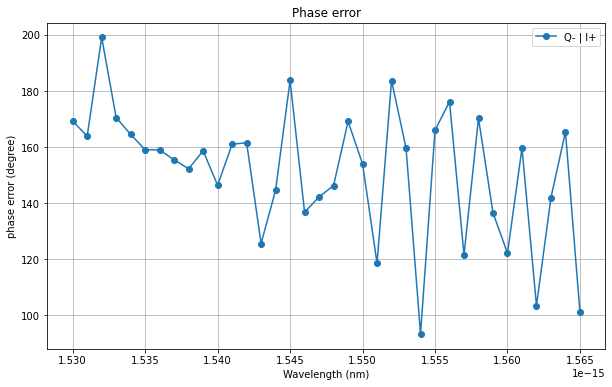

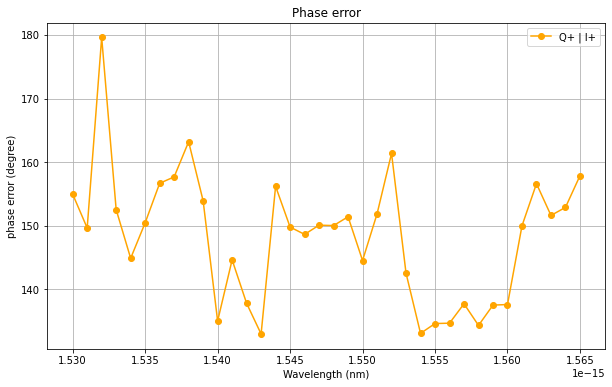

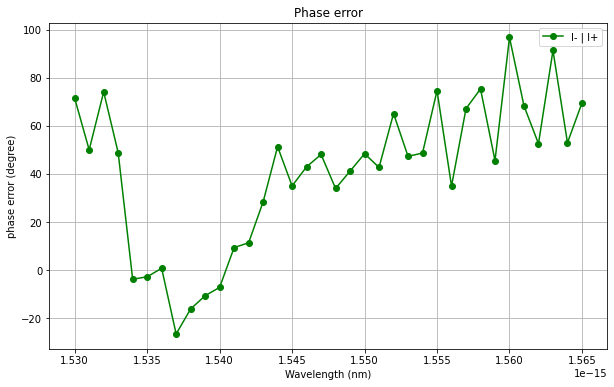

In [156]:
fig = plt.figure(figsize = (10, 6))
plt.plot(CFreqArray*1e-9,PError,'-o', label='Q- | I+')
plt.plot(CFreqArray*1e-9,PError2,'-o',label='Q+ | I+')
plt.plot(CFreqArray*1e-9,PError3,'-o',label='I- | I+')
plt.grid(True)
plt.legend()
plt.title('Phase error')
plt.xlabel('Wavelength (nm)')
plt.ylabel('phase error (degree)')

fig = plt.figure(figsize = (10, 6))
plt.plot(CFreqArray*1e-9,PError,'-o', label='Q- | I+')
plt.grid(True)
plt.legend()
plt.title('Phase error')
plt.xlabel('Wavelength (nm)')
plt.ylabel('phase error (degree)')

fig = plt.figure(figsize = (10, 6))
plt.plot(CFreqArray*1e-9,PError2,'-o',label='Q+ | I+', color='orange')
plt.grid(True)
plt.legend()
plt.title('Phase error')
plt.xlabel('Wavelength (nm)')
plt.ylabel('phase error (degree)')

fig = plt.figure(figsize = (10, 6))
plt.plot(CFreqArray*1e-9,PError3,'-o',label='I- | I+', color='g')
plt.grid(True)
plt.legend()
plt.title('Phase error')
plt.xlabel('Wavelength (nm)')
plt.ylabel('phase error (degree)')

8
[3.24417119e-03 1.49569003e+01]
[3.17982184e+11 6.34931287e+11 9.50852336e+11 1.26575032e+12
 1.57963021e+12 1.89249693e+12 2.20435538e+12 2.51521043e+12]


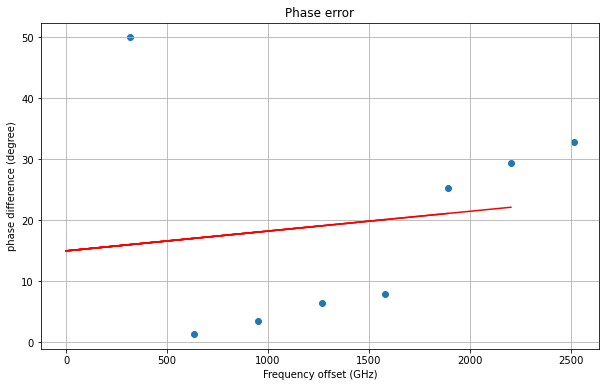

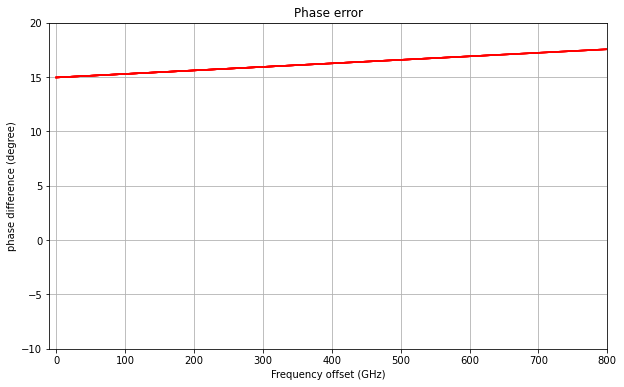

In [135]:
print(len(PhaseArray))
linepoly = np.polyfit(FreqArray*1e-9,PhaseArray3,1)
print(linepoly)

lineArray = np.linspace(0,FreqArray[:-1],10)

fig = plt.figure(figsize = (10, 6))
plt.scatter(FreqArray*1e-9,PhaseArray3)
plt.plot(lineArray*1e-9,linepoly[1]+linepoly[0]*lineArray*1e-9,color='red')
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset (GHz)')
plt.ylabel('phase difference (degree)')

fig = plt.figure(figsize = (10, 6))
plt.scatter(FreqArray*1e-9,PhaseArray)
plt.plot(lineArray*1e-9,linepoly[1]+linepoly[0]*lineArray*1e-9,color='red')
plt.ylim(-10,20)
plt.xlim(-10,800)
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset (GHz)')
plt.ylabel('phase difference (degree)')

print(FreqArray)

36


Text(0.5, 1.0, 'QN (90)')

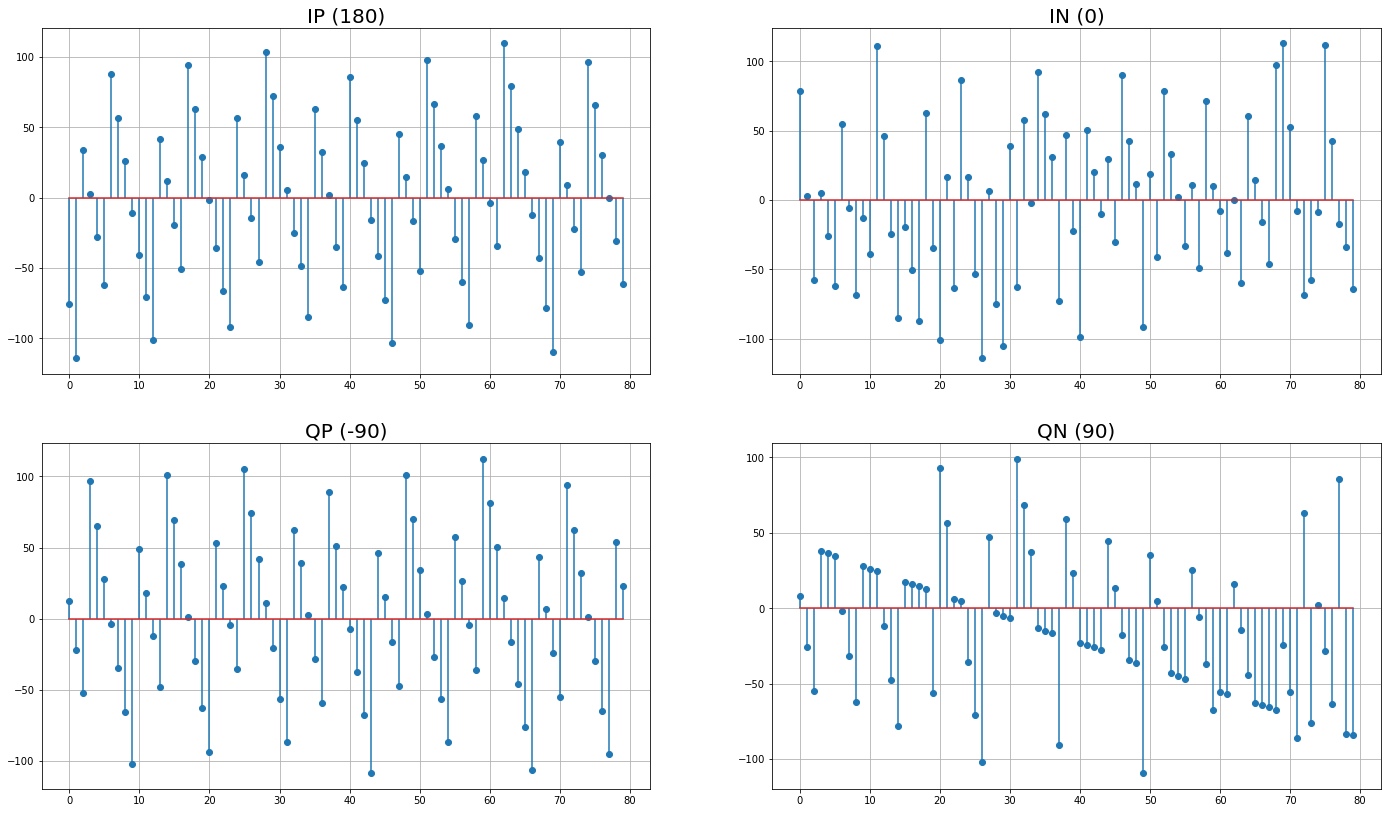

In [174]:
#DebugIP[i,j] 
#DebugIN[i,j]
#DebugQP[i,j]
#DebugQN[i,j]

print(len(DebugIP[0,:]))
j = 15 # Index

fig, ax= plt.subplots(2,2,figsize=(24,14))
ax[0][0].stem(xarray,DebugIP[:,j])
ax[0][0].grid(True)
ax[0][0].set_title("IP (180)", fontsize=20)

ax[0][1].stem(xarray,DebugIN[:,j])
ax[0][1].grid(True)
ax[0][1].set_title("IN (0)", fontsize=20)

ax[1][0].stem(xarray,DebugQP[:,j])
ax[1][0].grid(True)
ax[1][0].set_title("QP (-90)", fontsize=20)

ax[1][1].stem(xarray,DebugQN[:,j])
ax[1][1].grid(True)
ax[1][1].set_title("QN (90)", fontsize=20)
